# TensorFlow 2.0 alpha - Boosted Trees, DFCs, and Importances
## Local and Global Boosted Trees model interpretation - Titanic dataset

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from IPython.display import clear_output

import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

tf.random.set_seed(123)

# Create Feature Columns, Input Functions, and Train the Estimator
## Preprocess the Data - Create fc

In [4]:
# need to One-Hot the Categorical columns

fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                      'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
        fc.categorical_column_with_vocabulary_list(feature_name, vocab))

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

## Build the Input Pipeline
#### Create input_fn - using from_tensor_slices method
#### Read using Pandas - use entire Batch (small dataset)

In [5]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        dataset = (dataset.repeat(n_epochs).batch(NUM_EXAMPLES))
        return dataset
    return input_fn

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

## Train Model

In [6]:
# Getting DFCs requires center_bias = True (model makes prediction Before using features)

params = {
    'n_trees': 50,
    'max_depth': 3,
    'n_batches_per_layer': 1,
    'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)

est.train(train_input_fn, max_steps=100)

W0408 01:43:41.921021 140736985473984 estimator.py:1799] Using temporary folder as model directory: /var/folders/fn/10dyfg195751k6kfky4t_j7r0000gn/T/tmpl0auu8be
W0408 01:43:41.926002 140736985473984 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/canned/boosted_trees.py:296: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0408 01:43:41.966005 140736985473984 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and

## Evaluate Model

In [7]:
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.799242
accuracy_baseline,0.625000
auc,0.862810
auc_precision_recall,0.837517
average_loss,0.425395
label/mean,0.375000
loss,0.425395
precision,0.744681
prediction/mean,0.388308
recall,0.707071


# Model Interpretation and Plotting

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns_colors = sns.color_palette('colorblind')

## LOCAL Interpretability
#### Output the directional feature contributions DFCs - to explain individual predictions

In [9]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

#### Create DFC Pandas df

In [10]:
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe()

,age,sex,class,deck,embark_town,fare,n_siblings_spouses,parch,alone
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.0
mean,-0.027130,0.008026,0.017712,-0.016434,-0.006928,0.021175,0.003626,0.000700,0.0
std,0.078431,0.105867,0.092308,0.028123,0.026662,0.082724,0.021345,0.004726,0.0
min,-0.138235,-0.094709,-0.054615,-0.053134,-0.052648,-0.218280,-0.114192,-0.049681,0.0
25%,-0.076372,-0.072813,-0.045918,-0.041863,-0.014598,-0.021851,0.002558,0.000288,0.0
50%,-0.051975,-0.071653,-0.044871,-0.025701,-0.013914,-0.009081,0.002972,0.000336,0.0
75%,0.005251,0.136930,0.034011,0.005002,-0.002917,0.043043,0.005208,0.000638,0.0
max,0.346280,0.195177,0.232020,0.136349,0.065829,0.222620,0.107380,0.007024,0.0


## Directional Feature Contributions - DFCs
## Sum of the contributions + bias = prediction, of given example

In [12]:
# sum(DFCs) + bias == probability

bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

## Plot DFCs - for an individual passenger

In [13]:
def _get_color(value):
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
                fontproperties=font, size=12)

# view top 8 features - sort by magnitude

def plot_example(example):
    TOP_N = 8
    sorted_ix = example.abs().sort_values()[-TOP_N:].index
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(kind='barh',
                                color=[colors],
                                legend=None,
                                alpha=0.75,
                                figsize=(10,6))
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)

# add feature values

    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
    return ax

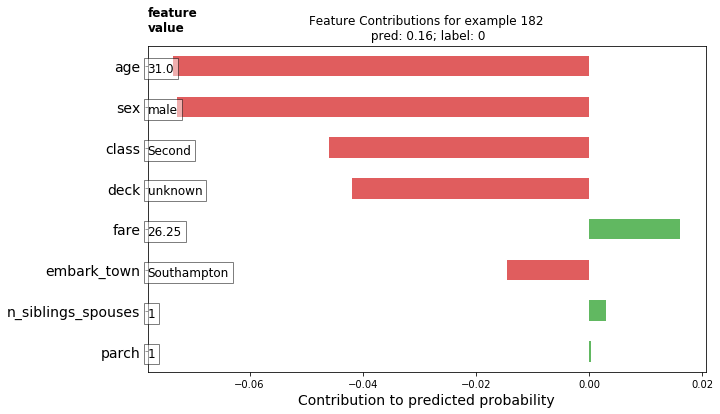

In [15]:
# Plot results for example # 182

ID = 182
example = df_dfc.iloc[ID]
TOP_N = 8
sorted_ix = example.abs().sort_values()[-TOP_N:].index

ax = plot_example(example)
ax.set_title('Feature Contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14);

#### Negative values reduce the model's prediction, positive values contribute to an increase
#### Plot the example's (182) DFCs compared with the Entire Distribution - VIOLIN plot

In [22]:
def dist_violin_plot(df_dfc, ID):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# create example df - view top 8 features 

    TOP_N = 8
    example = df_dfc.iloc[ID]
    ix = example.abs().sort_values()[-TOP_N:].index
    example = example[ix]
    example_df = example.to_frame(name='dfc')

# add Contributions to Entire Distribution

    parts=ax.violinplot([df_dfc[w] for w in ix],
                       vert=False,
                       showextrema=False,
                       widths=0.7,
                       positions=np.arange(len(ix)))
    face_color = sns_colors[0]
    alpha = 0.15
    for pc in parts['bodies']:
        pc.set_facecolor(face_color)
        pc.set_alpha(alpha)

# add Feature values

    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

# add Local Contributions    

    ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker='s',
              label='contributions for example')
    
    ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
           color=face_color, alpha=alpha, linewidth=10)
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                      frameon=True)
    legend.get_frame().set_facecolor('white')
    
    ax.set_yticks(np.arange(example.shape[0]))
    ax.set_yticklabels(example.index)
    ax.grid(False, axis='y')
    ax.set_xlabel('Contribution to predicted probability', size=14)

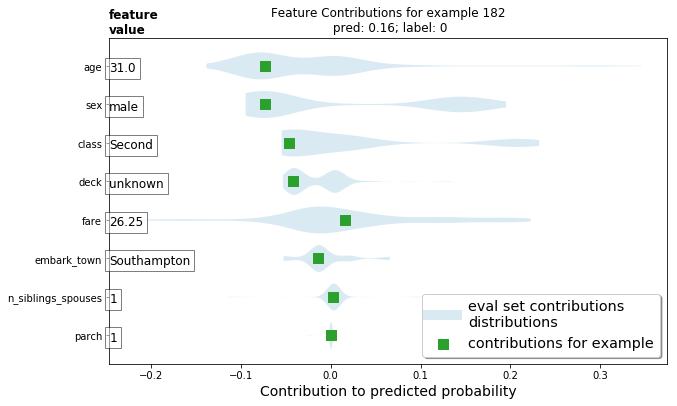

In [23]:
# plot example 182 against distribution

dist_violin_plot(df_dfc, ID)
plt.title('Feature Contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]));

## GLOBAL Feature Importances
### 1. Gain-based Feature Importances
#### Measure the Loss change when splitting on a particular Feature - use est.experimental_feature_importances

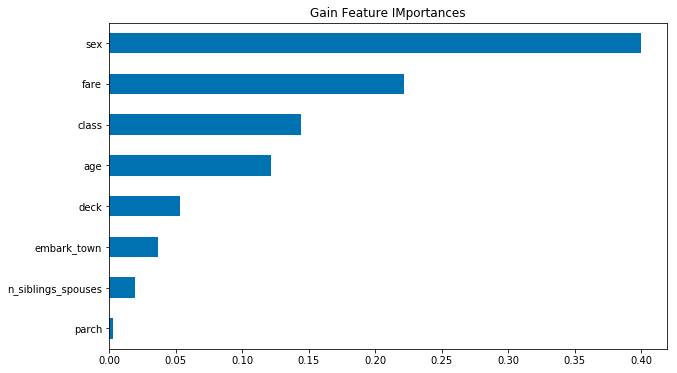

In [24]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# visualize importances

N = 8
ax = (df_imp.iloc[0:N][::-1]
     .plot(kind='barh',
          color=sns_colors[0],
          title='Gain Feature IMportances',
          figsize=(10,6)))
ax.grid(False, axis='y')

### 2. Average absolute DFCs

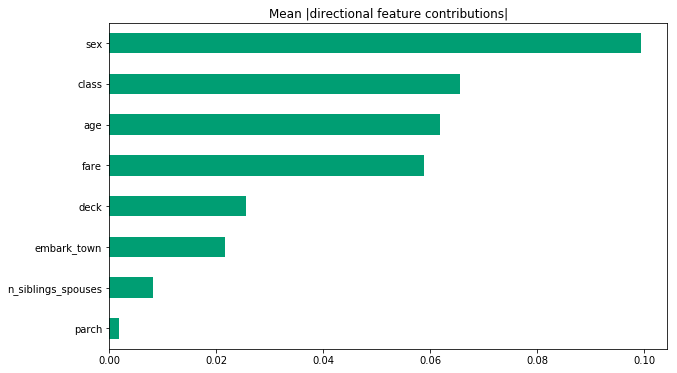

In [26]:
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index
ax = dfc_mean[sorted_ix].plot(kind='barh',
                              color=sns_colors[1],
                              title='Mean |directional feature contributions|',
                              figsize=(10,6))
ax.grid(False, axis='y')

#### See how DFCs vary as a Feature Value varies

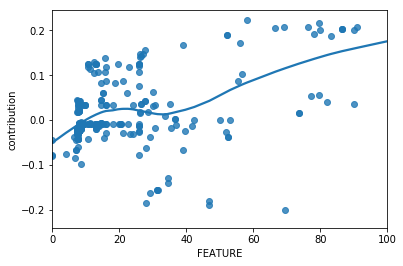

In [28]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True);
ax.set_ylabel('contribution')
ax.set_xlabel('FEATURE');
ax.set_xlim(0, 100);

### 3. Permutation Feature Importances
#### Generally considered better than Gain-based, though both have faults if predictor variable vary in scale or #
#### Computed by evaluating model performance on evaluation set - by Shuffling each Feature 1-by-1, attributing performance change to Shuffled Feature

W0408 03:01:07.386734 140736985473984 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0408 03:01:07.425843 140736985473984 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0408 03:01:09.315188 140736985473984 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0408 03:01:09.355493 140736985473984 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0408 03:01:11.249570 140736985473984 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0408 03:01:11.285992 140736985473984 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0408 03:0

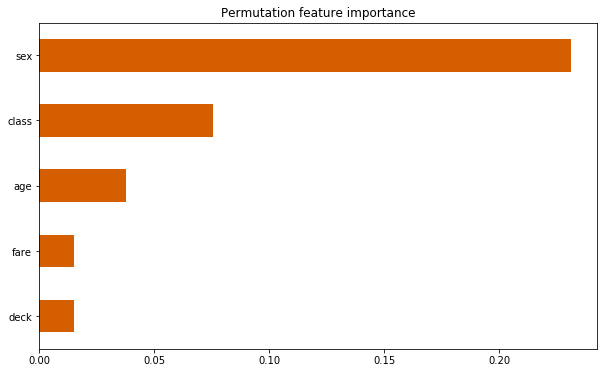

In [30]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    eval_input_fn = make_input_fn(X,
                                 y=y,
                                 shuffle=False,
                                 n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']

features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                     features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10,6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance');

# Visualize Model Fitting
#### Simulate/create training data with this formula:

#### z is the dependent variable to predict - x, y are the features

In [31]:
from numpy.random import uniform, seed
from matplotlib.mlab import griddata

# Create fake data

seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)

In [32]:
# Prep data for training

df = pd.DataFrame({'x': x, 'y':y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi, yi = np.meshgrid(xi, yi);

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

In [33]:
def plot_contour(x, y, z, **kwargs):
    plt.figure(figsize=(10,8))
    
    CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
    CS = plt.contourf(x, y, z, 15,
                     vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
    plt.colorbar()
    
    plt.xlim(-2,2)
    plt.ylim(-2,2)

#### Visualize the Function - redder colors correspond to larger function values

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  """Entry point for launching an IPython kernel.


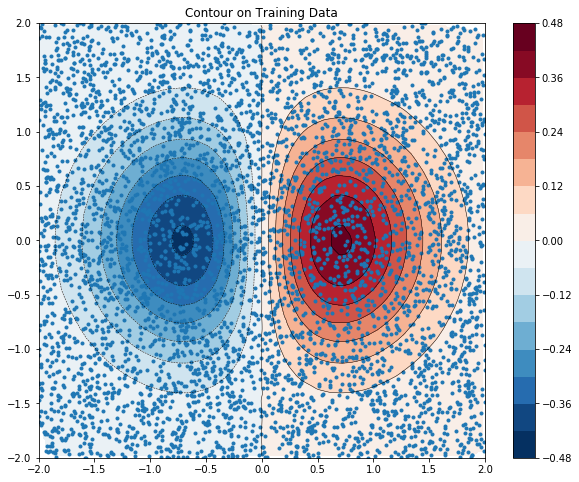

In [34]:
zi = griddata(x, y, z, xi, yi, interp='linear')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on Training Data');

In [35]:
fc = [tf.feature_column.numeric_column('x'),
     tf.feature_column.numeric_column('y')]

In [36]:
def predict(est):
    predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
    preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
    return preds.reshape(predict_shape)

#### Fit a Linear model to the data

train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

plot_contour(xi, yi, predict(est))

W0408 03:18:10.778103 140736985473984 estimator.py:1799] Using temporary folder as model directory: /var/folders/fn/10dyfg195751k6kfky4t_j7r0000gn/T/tmp_6kti0kj
W0408 03:18:11.085875 140736985473984 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


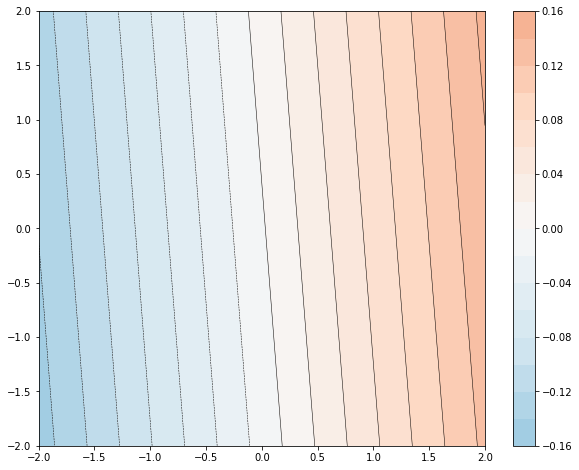

In [38]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

plot_contour(xi, yi, predict(est))

### Not a very good fit - Try a GBDT model - Attempt to understand how the model fits the function

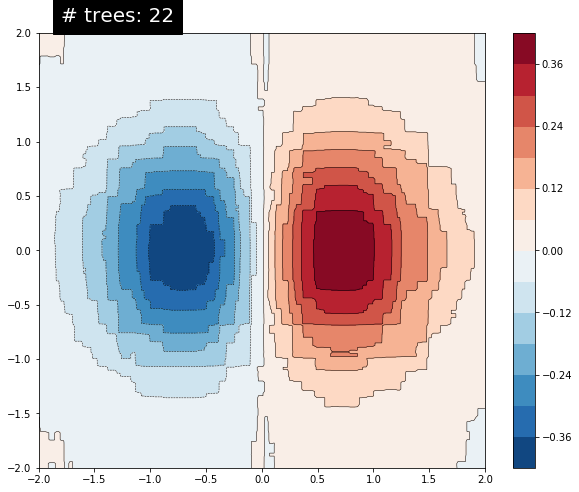

In [39]:
n_trees = 22

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20);

## As the number of Trees in Increased - the model's predictions better approximates the Underlying Function

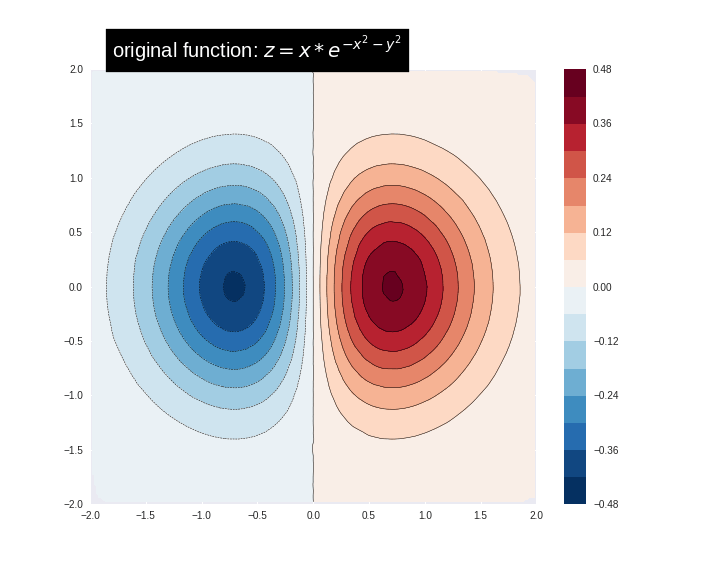

# Conclusion
### Using directional feature contributions DFCs and Feature Importance techniques, Boosted Trees models were interpreted - they help explain how Features impact a model's prediction 